# Code to generate all figures on tc events used in the paper


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
from extremeweatherbench import evaluate, calc, cases, defaults, inputs, metrics, regions, derived
sns.set_theme(style='whitegrid')
import shapely
from pathlib import Path
import multiprocessing
import xarray as xr
from matplotlib.lines import Line2D
import cartopy.crs as ccrs  # noqa: E402
import datetime

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

import src.plots.plotting_utils as plot_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402


In [4]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}
global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}
hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 



In [5]:
# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


# load results from the pickles

In [6]:
# load the results back in
fourv2_tc_results = pd.read_pickle(basepath + 'saved_data/fourv2_tc_results.pkl')
pang_tc_results = pd.read_pickle(basepath + 'saved_data/pang_tc_results.pkl')
hres_tc_results = pd.read_pickle(basepath + 'saved_data/hres_tc_results.pkl')
gc_tc_results = pd.read_pickle(basepath + 'saved_data/gc_tc_results.pkl')


In [13]:
fourv2_tc_results


,value,lead_time,init_time,target_variable,metric,forecast_source,target_source,case_id_number,event_type
0,NaN,NaN,0,surface_wind_speed,landfall_displacement,CIRA FOURv2 GFS,IBTrACS,151,tropical_cyclone
1,NaN,NaN,0,air_pressure_at_mean_sea_level,landfall_displacement,CIRA FOURv2 GFS,IBTrACS,151,tropical_cyclone
2,NaN,NaN,0,surface_wind_speed,landfall_time_me,CIRA FOURv2 GFS,IBTrACS,151,tropical_cyclone
3,NaN,NaN,0,air_pressure_at_mean_sea_level,landfall_time_me,CIRA FOURv2 GFS,IBTrACS,151,tropical_cyclone
4,NaN,NaN,0,surface_wind_speed,landfall_intensity_mae,CIRA FOURv2 GFS,IBTrACS,151,tropical_cyclone
...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,0,air_pressure_at_mean_sea_level,landfall_displacement,CIRA FOURv2 GFS,IBTrACS,253,tropical_cyclone
422,NaN,NaN,0,surface_wind_speed,landfall_time_me,CIRA FOURv2 GFS,IBTrACS,253,tropical_cyclone
423,NaN,NaN,0,air_pressure_at_mean_sea_level,landfall_time_me,CIRA FOURv2 GFS,IBTrACS,253,tropical_cyclone
424,NaN,NaN,0,surface_wind_speed,landfall_intensity_mae,CIRA FOURv2 GFS,IBTrACS,253,tropical_cyclone


# plotting and subsetting code at the global level

In [10]:
fourv2_gfs_era5_settings_tc = fourv2_gfs_cira_settings | fourv2_style | era5_group_style   
gc_gfs_era5_settings_tc  = gc_gfs_cira_settings | gc_style | era5_group_style
pangu_gfs_era5_settings_tc = pangu_gfs_cira_settings | pangu_style | era5_group_style
hres_era5_settings_tc = hres_ifs_settings | hres_style | hres_group_style

fourv2_tc_plot_displacement = results_utils.subset_results_to_xarray(results_df=fourv2_tc_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_displacement', init_time='zeroz')
gc_tc_plot_displacement = results_utils.subset_results_to_xarray(results_df=gc_tc_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_displacement', init_time='zeroz')
pangu_tc_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_tc_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_displacement', init_time='zeroz')
hres_tc_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_tc_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_displacement', init_time='zeroz')

# plot the results
tc_data_displacement = [fourv2_tc_plot_displacement, gc_tc_plot_displacement, 
    pangu_tc_plot_csi, hres_tc_plot_csi]
tc_settings = [fourv2_gfs_era5_settings_tc, gc_gfs_era5_settings_tc, 
    pangu_gfs_era5_settings_tc, hres_era5_settings_tc]

fourv2_tc_plot_time_me = results_utils.subset_results_to_xarray(results_df=fourv2_tc_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_time_mean', init_time='zeroz')
gc_tc_plot_time_me = results_utils.subset_results_to_xarray(results_df=gc_tc_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_time_mean', init_time='zeroz')
pangu_tc_plot_time_me  = results_utils.subset_results_to_xarray(results_df=pang_tc_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_time_mean', init_time='zeroz')
hres_tc_plot_time_me = results_utils.subset_results_to_xarray(results_df=hres_tc_results, 
    forecast_source=hres_era5_settings_tc['forecast_source'], 
    target_source='IBTrACS', metric='landfall_time_mean', init_time='zeroz')

tc_data_time_me = [fourv2_tc_plot_time_me, gc_tc_plot_time_me, 
    pangu_tc_plot_time_me, hres_tc_plot_time_me]

fourv2_tc_intensity = results_utils.subset_results_to_xarray(results_df=fourv2_tc_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_intensity_mae', init_time='zeroz')
gc_tc_intensity = results_utils.subset_results_to_xarray(results_df=gc_tc_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_intensity_mae', init_time='zeroz')
pangu_tc_intensity  = results_utils.subset_results_to_xarray(results_df=pang_tc_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_intensity_mae', init_time='zeroz')
hres_tc_intensity = results_utils.subset_results_to_xarray(results_df=hres_tc_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='IBTrACS', metric='landfall_intensity_mae', init_time='zeroz')

tc_intensity = [fourv2_tc_intensity, gc_tc_intensity, pangu_tc_intensity, hres_tc_intensity]


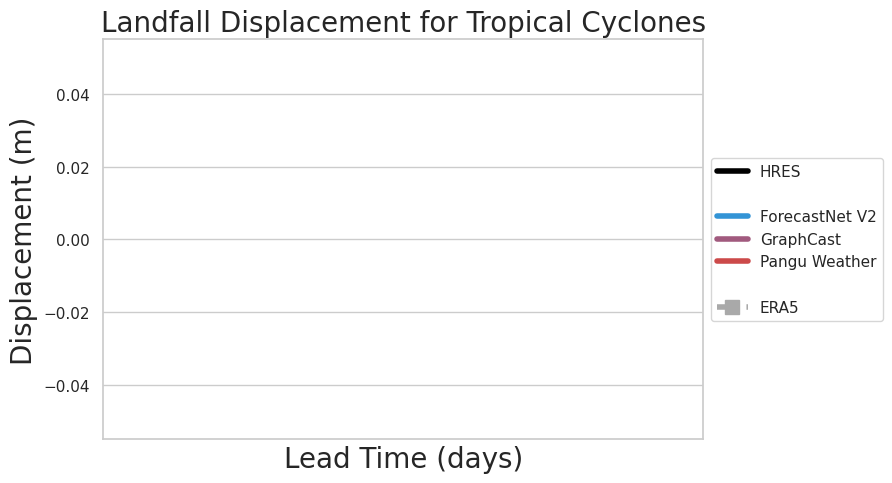

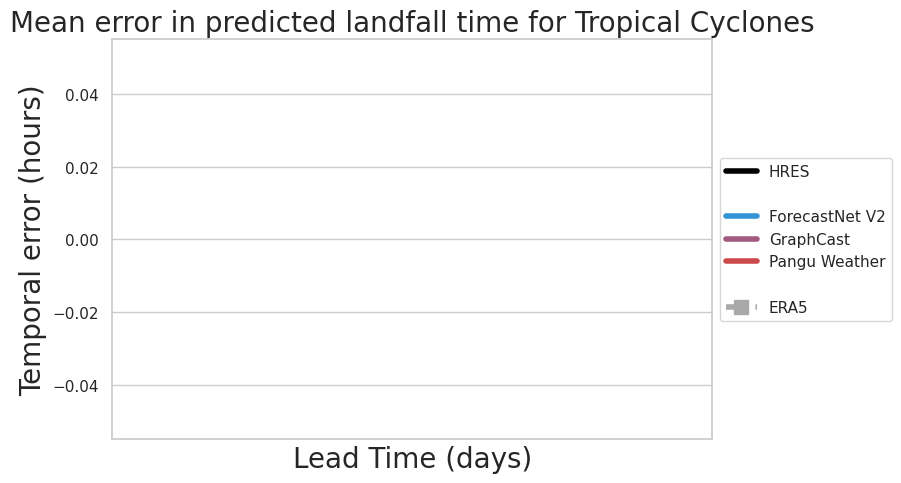

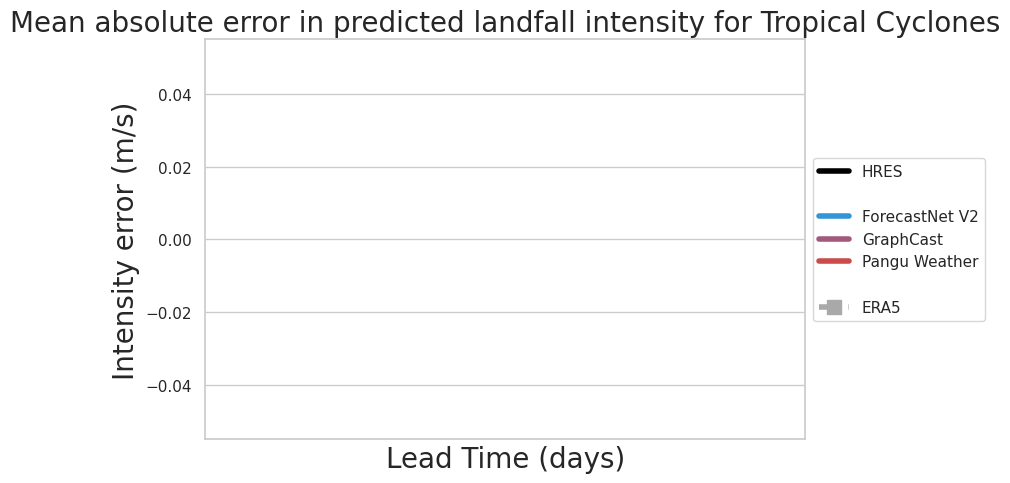

In [11]:
plot_utils.plot_results_by_metric(data=tc_data_displacement, settings=tc_settings, 
    title='Landfall Displacement for Tropical Cyclones', 
    show_all_in_legend=False, y_label='Displacement (m)')
plot_utils.plot_results_by_metric(data=tc_data_time_me, settings=tc_settings, 
    title='Mean error in predicted landfall time for Tropical Cyclones', 
    show_all_in_legend=False, y_label='Temporal error (hours)')
plot_utils.plot_results_by_metric(data=tc_intensity, settings=tc_settings, 
    title='Mean absolute error in predicted landfall intensity for Tropical Cyclones', 
    show_all_in_legend=False, y_label='Intensity error (m/s)')


# analysis at the regional level

North America Cases: [1, 2, 3, 4, 5, 6, 27, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 84, 87, 88, 89, 95, 96, 97, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 118, 119, 121, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 194, 195, 196, 197, 198, 199, 200, 201, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
Australia Ca

/home/amy/extreme-weather-bench-paper/src/plots/plotting_utils.py:1185: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower left", fontsize=12)


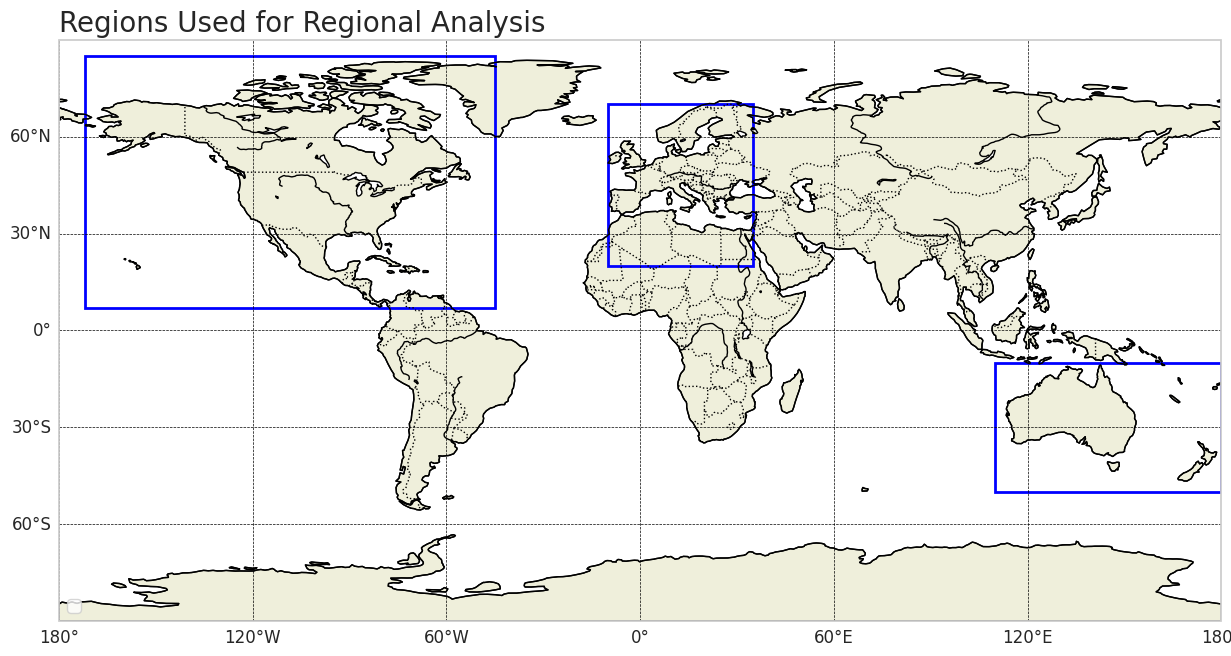

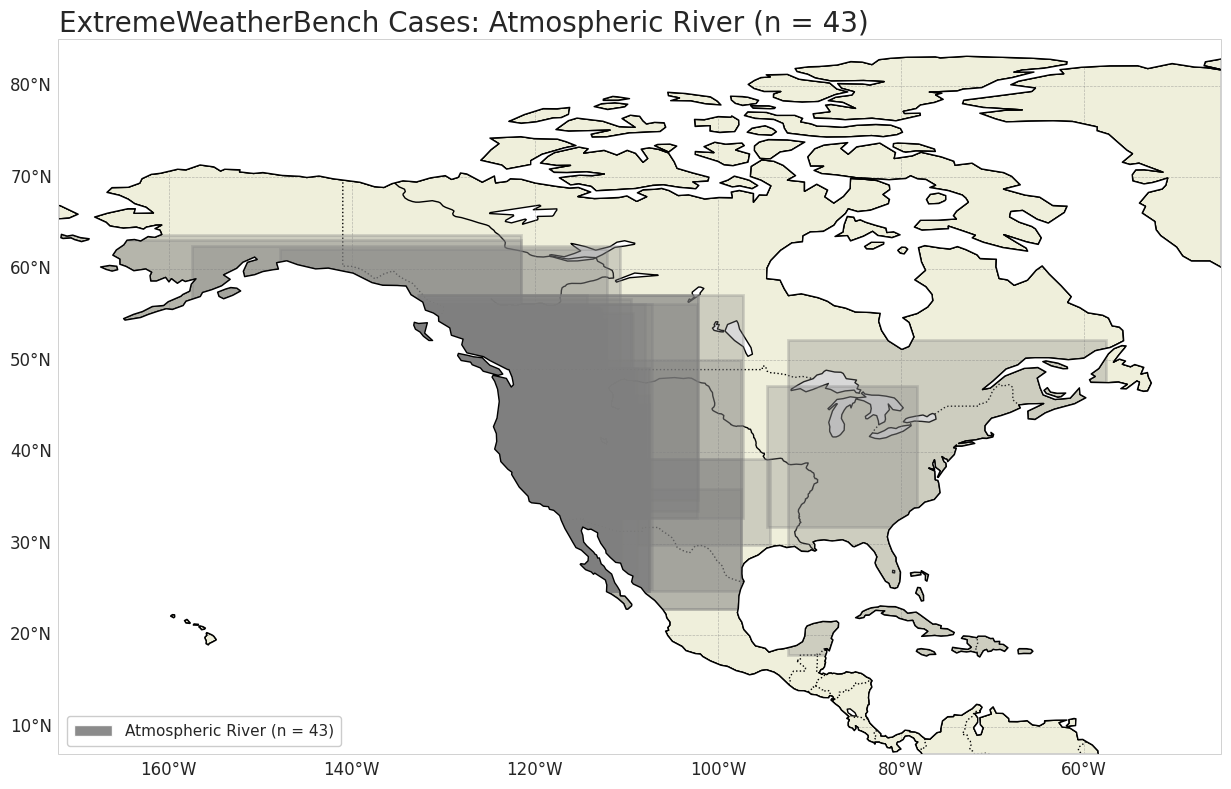

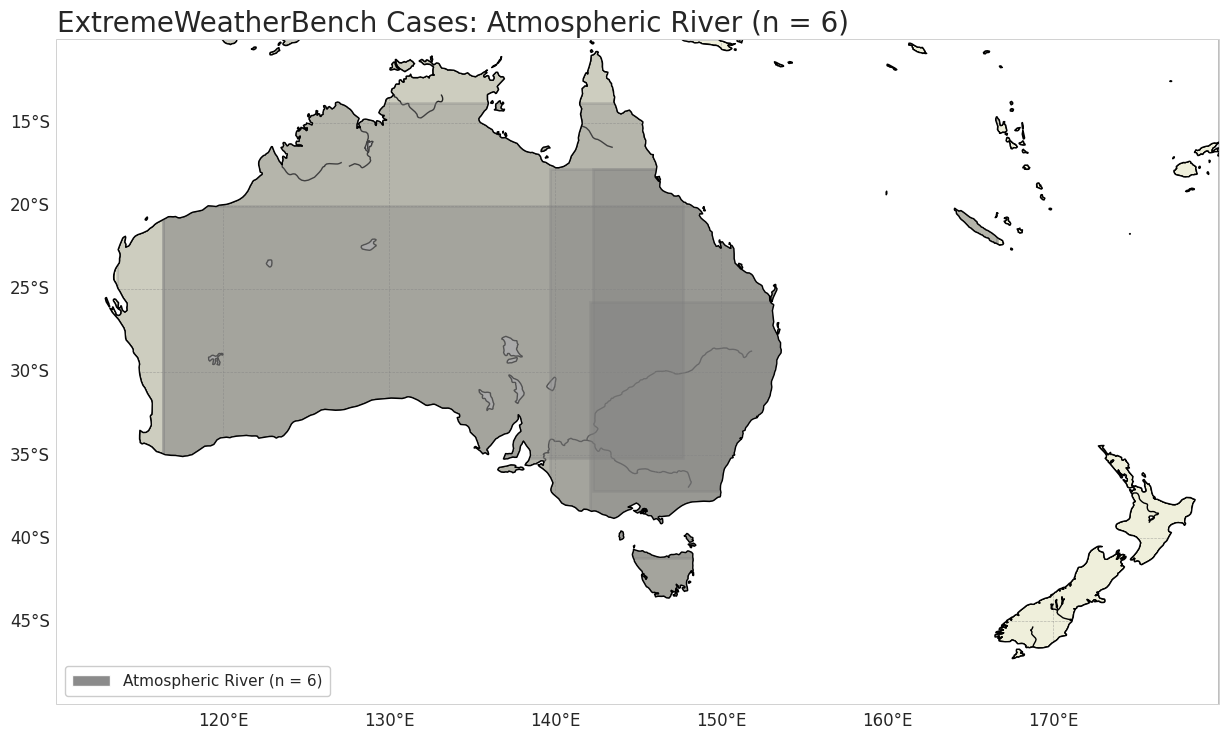

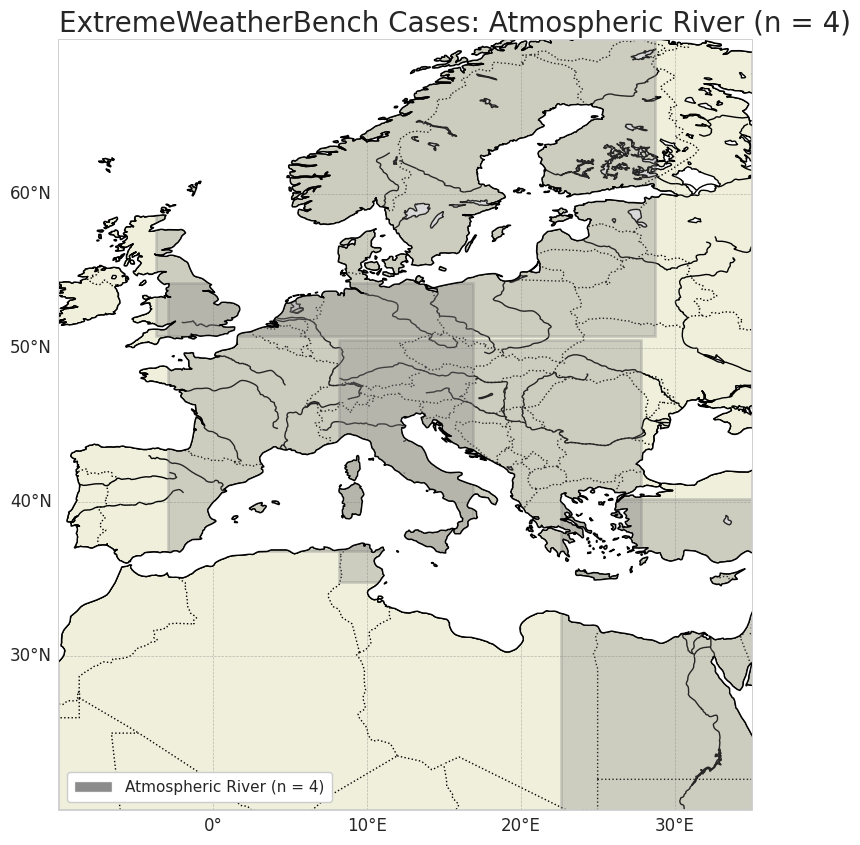

In [8]:
# make the bounding boxes for the regions

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# europe bounding box
eu_bounding_box = [-10, 35, 20, 70]
eu_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(eu_bounding_box)
eu_bounding_region = regions.BoundingBoxRegion(latitude_min=20, latitude_max=70, longitude_min=-10, longitude_max=35)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(au_bounding_box)
au_bounding_region = regions.BoundingBoxRegion(latitude_min=-50, latitude_max=-10, longitude_min=110, longitude_max=180)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
au_subset = regions.RegionSubsetter(region=au_bounding_region, method='intersects').subset_case_collection(ewb_cases)
eu_subset = regions.RegionSubsetter(region=eu_bounding_region, method='intersects').subset_case_collection(ewb_cases)
na_case_ids = [n.case_id_number for n in na_subset.cases]
au_case_ids = [n.case_id_number for n in au_subset.cases]
eu_case_ids = [n.case_id_number for n in eu_subset.cases]

print(f'North America Cases: {na_case_ids}')
print(f'Australia Cases: {au_case_ids}')
print(f'Europe Cases: {eu_case_ids}')

# plot the regions
plot_utils.plot_boxes(
    box_list=[na_bounding_box_polygon, au_bounding_box_polygon, eu_bounding_box_polygon],
    box_names=['North America', 'Europe', 'Australia'],
    title='Regions Used for Regional Analysis',
)

# plot North America cases
plot_utils.plot_all_cases(ewb_cases, event_type='atmospheric_river', bounding_box=na_bounding_box, 
    fill_boxes=True)

plot_utils.plot_all_cases(ewb_cases, event_type='atmospheric_river', bounding_box=au_bounding_box, 
    fill_boxes=True)

plot_utils.plot_all_cases(ewb_cases, event_type='atmospheric_river', bounding_box=eu_bounding_box, 
    fill_boxes=True)

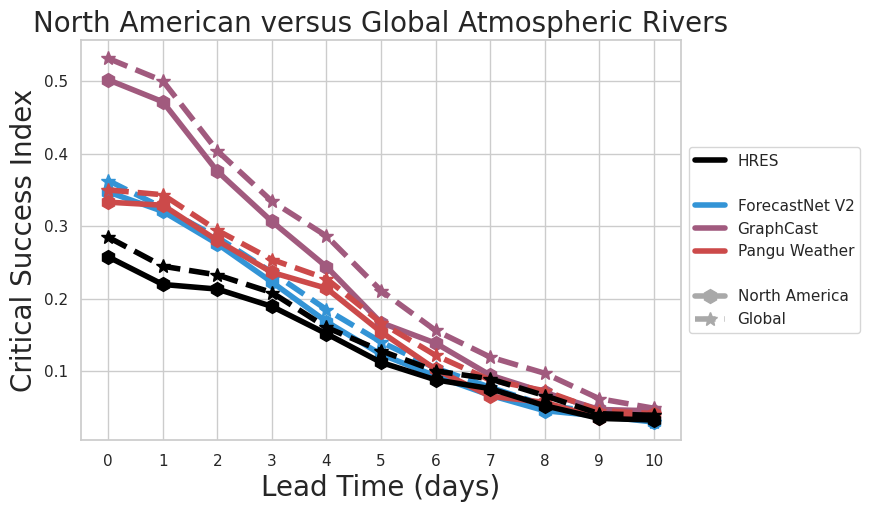

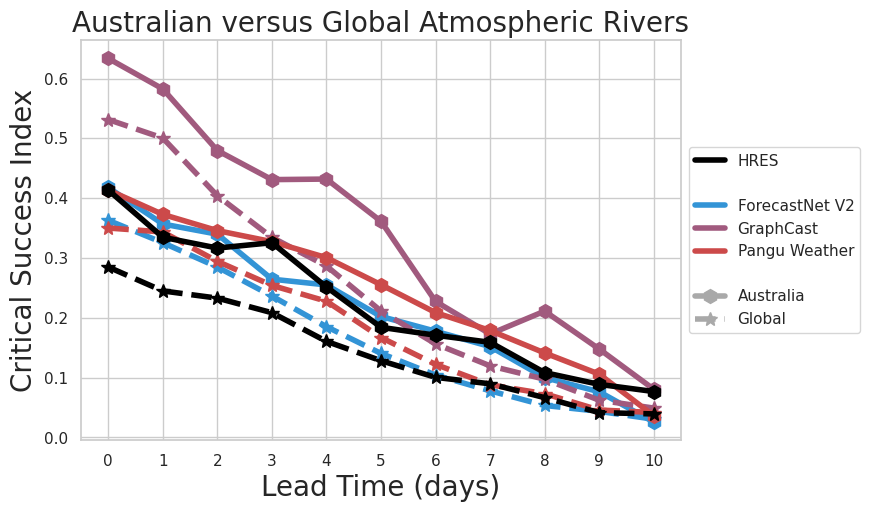

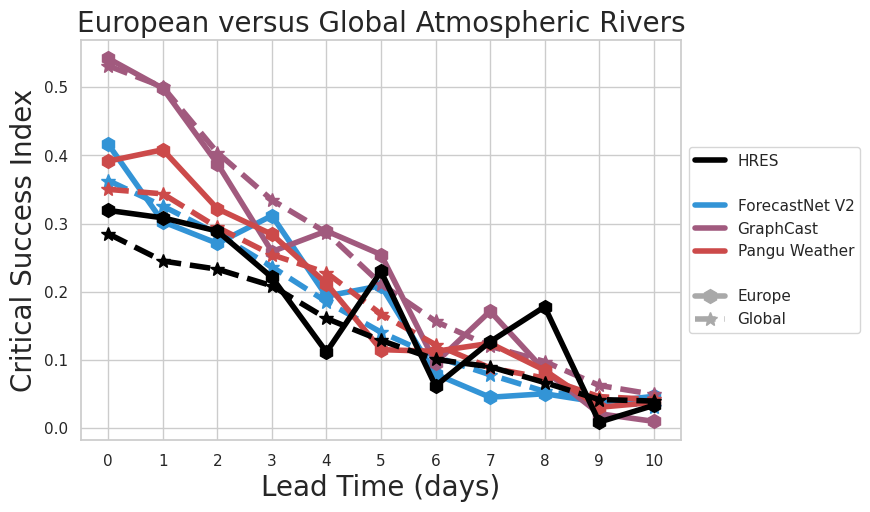

In [9]:
# create a group style for the local/global plots
na_group_style = {'linestyle':'-', 'marker':'h', 'group':'North America'}
au_group_style = {'linestyle':'-', 'marker':'h', 'group':'Australia'}
eu_group_style = {'linestyle':'-', 'marker':'h', 'group':'Europe'}
# plot the results for one metric for the three AI models versus HRES
na_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | na_group_style
na_gc_gfs_settings = gc_gfs_cira_settings | gc_style | na_group_style
na_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | na_group_style
na_hres_settings = hres_ifs_settings | hres_style | na_group_style

au_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | au_group_style
au_gc_gfs_settings = gc_gfs_cira_settings | gc_style | au_group_style
au_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | au_group_style
au_hres_settings = hres_ifs_settings | hres_style | au_group_style

eu_fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | eu_group_style
eu_gc_gfs_settings = gc_gfs_cira_settings | gc_style | eu_group_style
eu_pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | eu_group_style
eu_hres_settings = hres_ifs_settings | hres_style | eu_group_style

# subset the data for the plots
na_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)
na_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=na_case_ids)

# subset the data for the plots
au_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)
au_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=au_case_ids)

# subset europe
eu_fourv2_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_gc_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_pangu_severe_plot_csi  = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)
eu_hres_severe_plot_csi = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz',
    case_id_list=eu_case_ids)


# make a global settings so we can compare
fourv2_global_settings = fourv2_gfs_cira_settings | fourv2_style | global_group_style
pangu_global_settings = pangu_gfs_cira_settings | pangu_style | global_group_style
gc_global_settings = gc_gfs_cira_settings | gc_style | global_group_style
hres_global_settings = hres_ifs_settings | hres_style | global_group_style 

# plot the results
na_data = [na_fourv2_severe_plot_csi, fourv2_ar_plot_csi, na_gc_severe_plot_csi, 
    gc_ar_plot_csi, na_pangu_severe_plot_csi, pangu_ar_plot_csi, 
    na_hres_severe_plot_csi, hres_ar_plot_csi]
settings = [na_fourv2_gfs_settings, fourv2_global_settings, na_gc_gfs_settings, gc_global_settings, 
    na_pangu_gfs_settings, pangu_global_settings, na_hres_settings, hres_global_settings]
plot_utils.plot_results_by_metric(data=na_data, settings=settings, 
    title='North American versus Global Atmospheric Rivers', y_label='Critical Success Index')

au_data = [au_fourv2_severe_plot_csi, fourv2_ar_plot_csi, au_gc_severe_plot_csi, gc_ar_plot_csi, 
    au_pangu_severe_plot_csi, pangu_ar_plot_csi, au_hres_severe_plot_csi, hres_ar_plot_csi]
settings = [au_fourv2_gfs_settings, fourv2_global_settings, au_gc_gfs_settings, gc_global_settings, 
    au_pangu_gfs_settings, pangu_global_settings, au_hres_settings, hres_global_settings]
plot_utils.plot_results_by_metric(data=au_data, settings=settings, 
    title='Australian versus Global Atmospheric Rivers', y_label='Critical Success Index')

eu_data = [eu_fourv2_severe_plot_csi, fourv2_ar_plot_csi, eu_gc_severe_plot_csi, gc_ar_plot_csi, 
    eu_pangu_severe_plot_csi, pangu_ar_plot_csi, eu_hres_severe_plot_csi, hres_ar_plot_csi]
settings = [eu_fourv2_gfs_settings, fourv2_global_settings, eu_gc_gfs_settings, gc_global_settings, 
    eu_pangu_gfs_settings, pangu_global_settings, eu_hres_settings, hres_global_settings]
plot_utils.plot_results_by_metric(data=eu_data, settings=settings, 
    title='European versus Global Atmospheric Rivers', y_label='Critical Success Index')



# dive into one example in depth

In [12]:
# loop through the results and find all the case studies that have non-zero results for each model
valid_case_ids = []
for case_id in hres_ar_results.case_id_number.unique():
    hres_subset = results_utils.subset_results_to_xarray(results_df=hres_ar_results, 
        forecast_source=hres_ifs_settings['forecast_source'], 
        target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz', case_id_list=[case_id])
    if hres_subset.value.sum() > 0:
        #print(f'Case {case_id} has non-zero results for HRES')

        gc_subset = results_utils.subset_results_to_xarray(results_df=gc_ar_results, 
            forecast_source=gc_gfs_cira_settings['forecast_source'], 
            target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz', case_id_list=[case_id])
        if gc_subset.value.sum() > 0:
            #print(f'Case {case_id} has non-zero results for GraphCast')

            pang_subset = results_utils.subset_results_to_xarray(results_df=pang_ar_results, 
                forecast_source=pangu_gfs_cira_settings['forecast_source'], 
                target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz', case_id_list=[case_id])
            if pang_subset.value.sum() > 0:
                #print(f'Case {case_id} has non-zero results for Pangu')

                fourv2_subset = results_utils.subset_results_to_xarray(results_df=fourv2_ar_results, 
                    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
                    target_source='ERA5', metric='CriticalSuccessIndex', init_time='zeroz', case_id_list=[case_id])
                if fourv2_subset.value.sum() > 0:
                    #print(f'Case {case_id} has non-zero results for ForecastNet V2')

                    valid_case_ids.append(case_id)
                
print(valid_case_ids)

[112, 113, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 127, 128]


In [10]:
# load in the graphics objects
hres_graphics = pd.read_pickle(basepath + 'saved_data/hres_ar_graphics.pkl')
pangu_graphics = pd.read_pickle(basepath + 'saved_data/pang_ar_graphics.pkl')
fourv2_graphics = pd.read_pickle(basepath + 'saved_data/fourv2_ar_graphics.pkl')
gc_graphics = pd.read_pickle(basepath + 'saved_data/gc_ar_graphics.pkl')


In [11]:
my_id = 112
my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]

In [12]:
def select_ivt_and_maks(graphics_obect, lead_time_hours):
    # select the right lead time
    lead_time_td = pd.Timedelta(hours=lead_time_hours)
    ivt = graphics_obect.integrated_vapor_transport.sel(lead_time=lead_time_td, method="nearest")
    ar_mask = graphics_obect.atmospheric_river_mask.sel(lead_time=lead_time_td, method="nearest")

    # select the right valid time (hack for now to always select the first valid time)
    valid_time = graphics_obect.integrated_vapor_transport.valid_time[0]
    ivt2 = ivt.sel(valid_time=valid_time, method="nearest")
    ar_mask2 = ar_mask.sel(valid_time=valid_time, method="nearest")
    return ivt2, ar_mask2


In [66]:
def plot_ar_full_panels(my_id, lead_time_hours):
    hres_ivt, hres_ar_mask = select_ivt_and_maks(hres_graphics[my_id], lead_time_hours)
    gc_ivt, gc_ar_mask = select_ivt_and_maks(gc_graphics[my_id], lead_time_hours)
    pangu_ivt, pangu_ar_mask = select_ivt_and_maks(pangu_graphics[my_id], lead_time_hours)
    fourv2_ivt, fourv2_ar_mask = select_ivt_and_maks(fourv2_graphics[my_id], lead_time_hours)

    # setup a four panel subplot with cartopy subfigures using GridSpec
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(12, 3))
    gs = GridSpec(1, 4, figure=fig, 
                  left=0.05, right=0.95, top=0.88, bottom=0.2,
                  wspace=0.4, hspace=0.1)
    
    # Create subplots with cartopy projection
    axs = []
    for i in range(4):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
        axs.append(ax)
    axs = np.array(axs)

    ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=hres_ivt, ar_mask=hres_ar_mask, 
        title="HRES", ax=axs[0], colorbar=False)

    ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=gc_ivt, ar_mask=gc_ar_mask, 
        title="GraphCast", ax=axs[1], colorbar=False)

    ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=pangu_ivt, ar_mask=pangu_ar_mask, 
        title="Pangu", ax=axs[2], colorbar=False)

    ar_plot_utils.plot_ar_mask_single_timestep(ivt_data=fourv2_ivt, ar_mask=fourv2_ar_mask, 
        title="ForecastNet V2", ax=axs[3], colorbar=False)

    # show the colorbar below the set of subplots
    # Create a ScalarMappable for the colorbar
    from matplotlib.cm import ScalarMappable
    cmap, norm = ar_plot_utils.setup_atmospheric_river_colormap_and_levels()
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array, we just need the colormap/norm
    
    # Add horizontal colorbar at the bottom
    cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', 
                        pad=0.2, shrink=0.9, aspect=30)
    cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=14)
    cbar.ax.tick_params(labelsize=12)

    valid_time = hres_graphics[my_id].integrated_vapor_transport.valid_time[0].values
    # convert the valid time to a datetime object
    valid_time_dt = pd.to_datetime(valid_time)
    # Use strftime() to format the string
    valid_time_str = valid_time_dt.strftime('%m/%d/%Y, %H:%M')
    fig.suptitle(f"Case id {my_id}, Valid Time: {valid_time_str}, Lead Time: {lead_time_hours} hours", size=16, y=0.98)

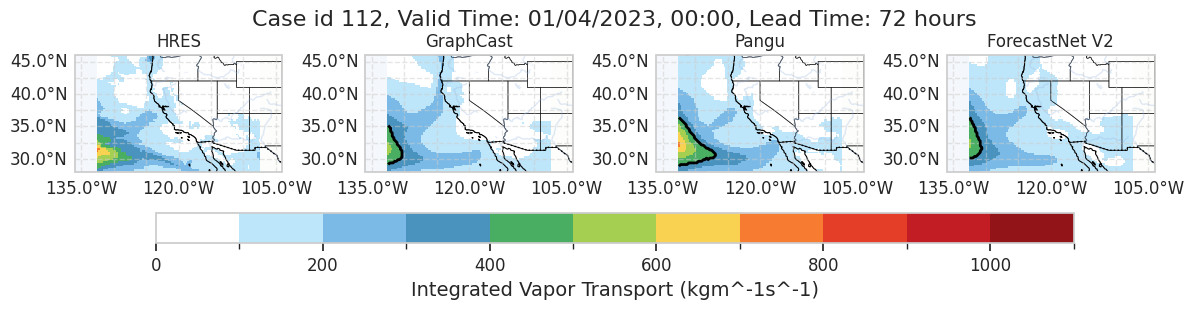

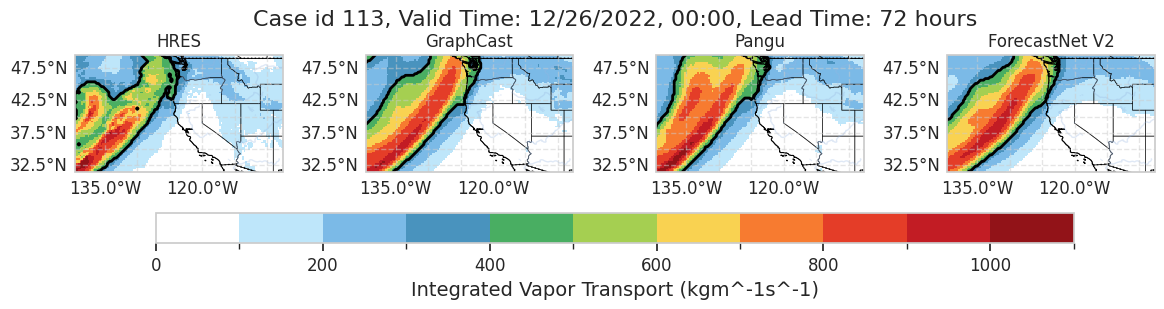

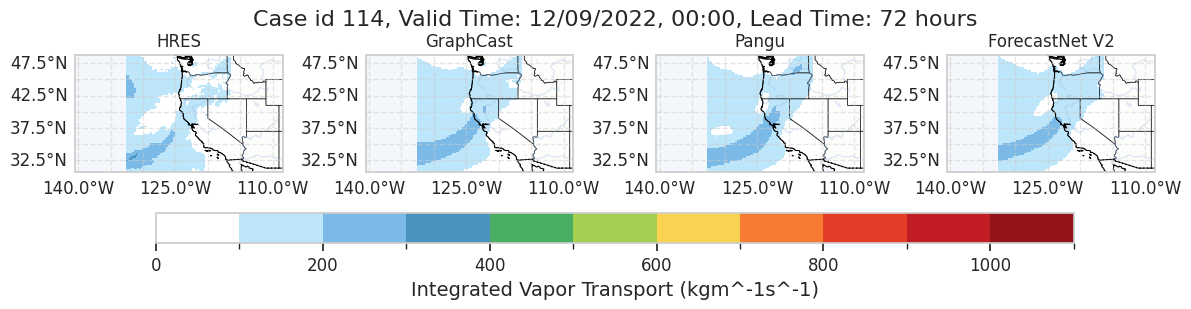

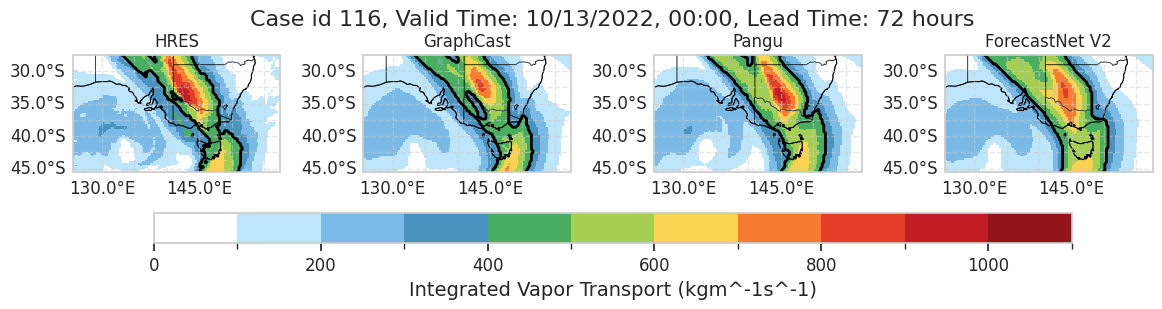

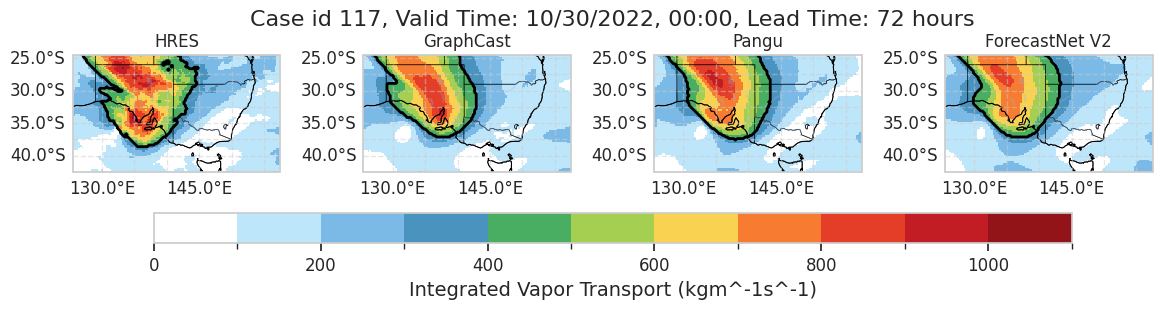

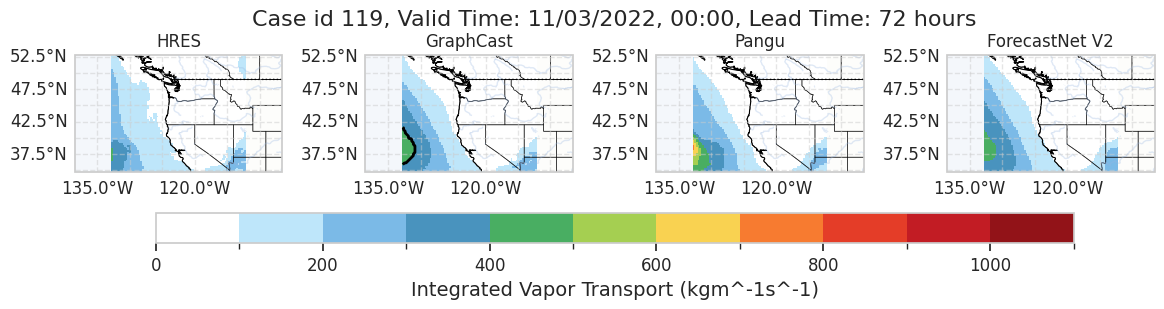

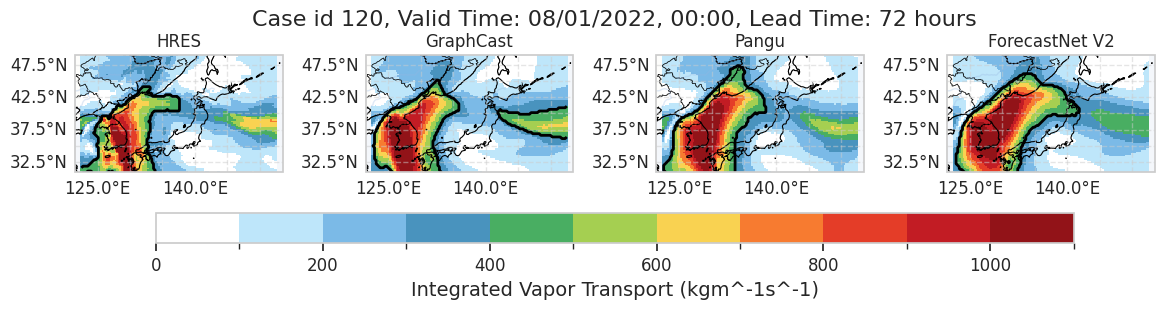

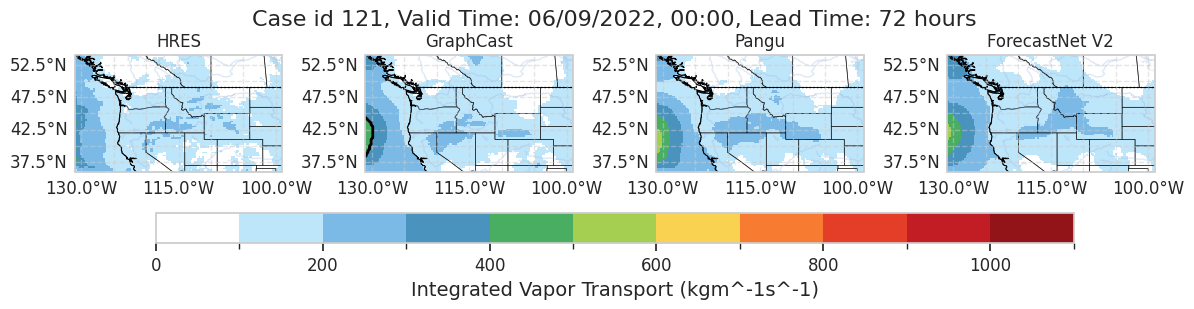

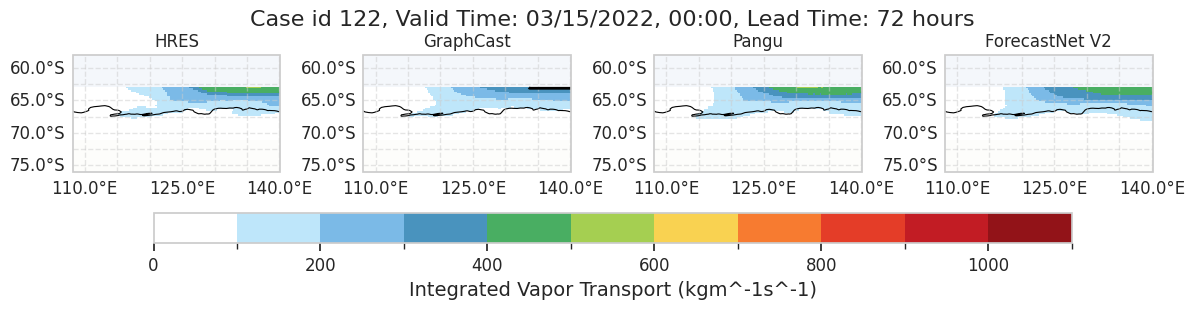

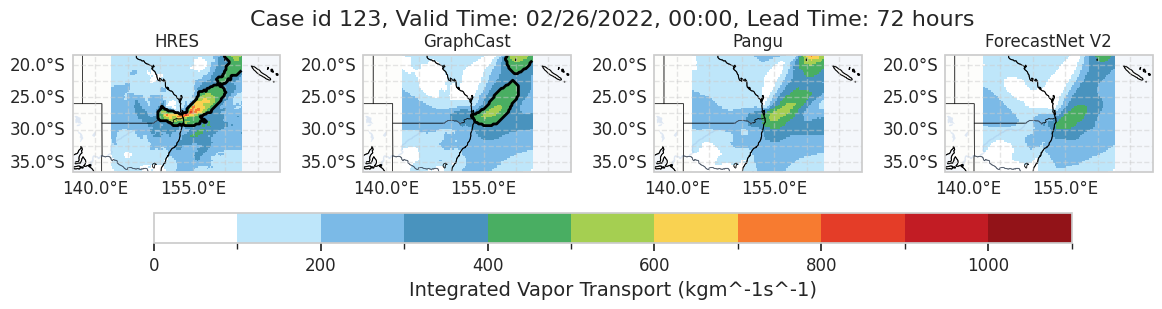

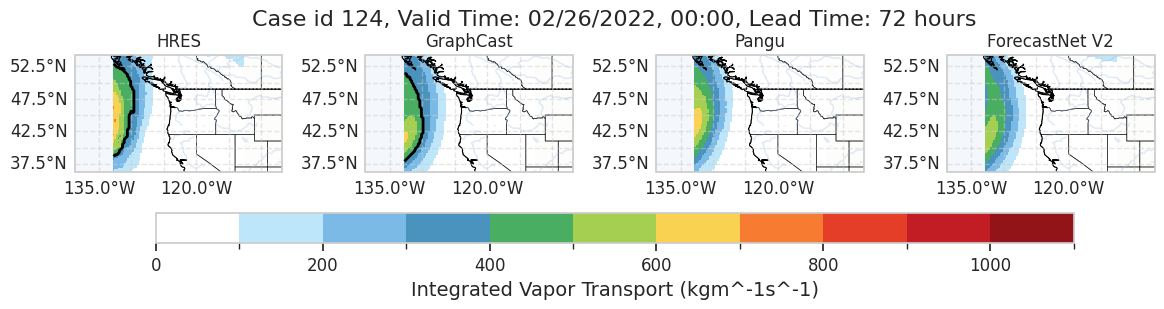

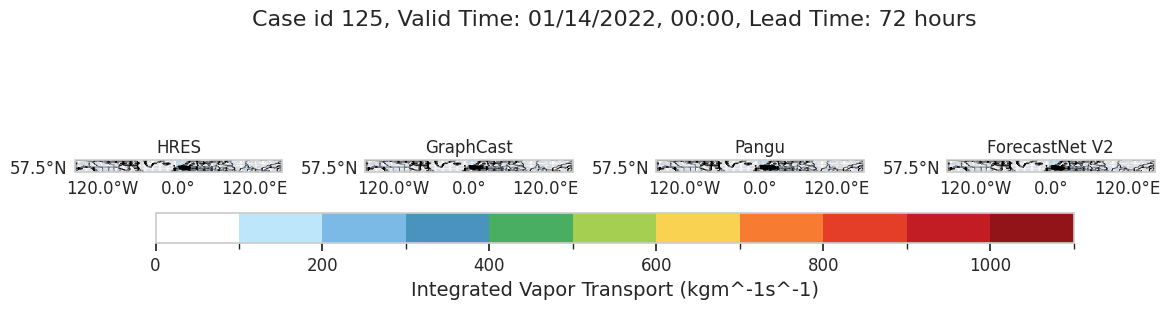

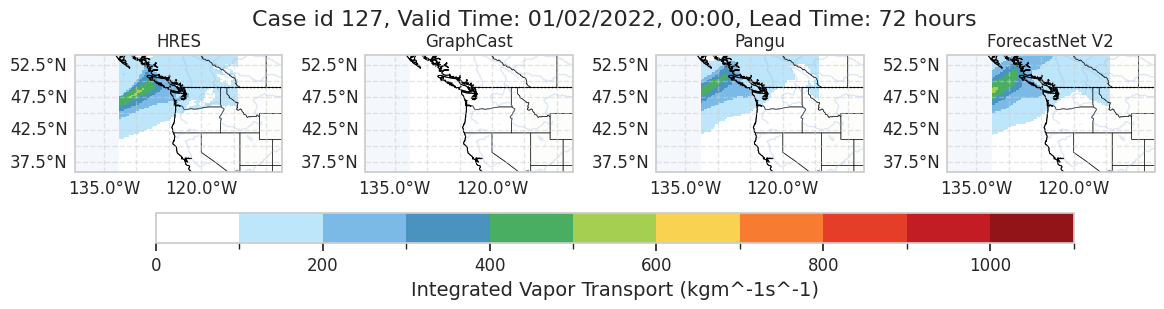

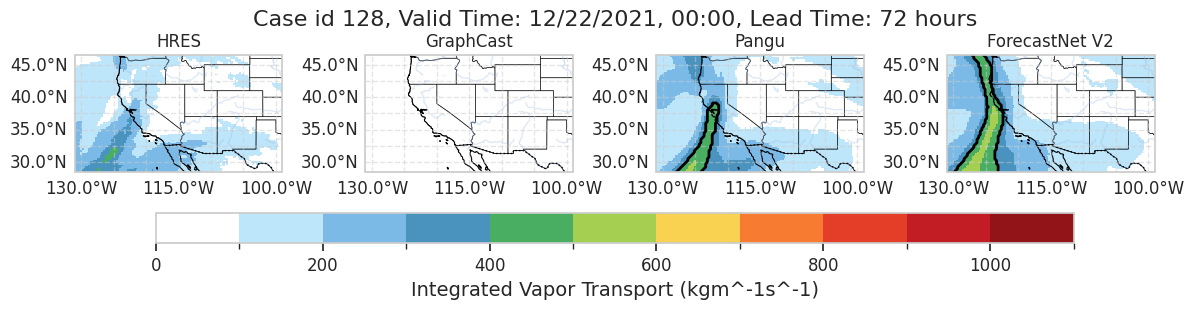

In [68]:
my_ids = [112, 113, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 127, 128]
lead_time_hours = 72

for my_id in my_ids:
    plot_ar_full_panels(my_id, lead_time_hours)
